### Rice Leaf Disease Analyzer
by Swagatam Roy


## Data Summary

- 120 jpg images of various sizes
- 3 classes --> leaf smut, brown spot and bacterial leaf blight
- 40 images per class
- There are no images of normal rice leaves i.e. not disease infected.
- 



## Approach

- Resize all images to 224x224x3
- Use 25 images from each class for training (105 training images)
- Use 5 images from each class for validation (15 validation images)
- Fine tune a Mobilenet model that was pre-trained on imagenet.
- Use Adam optimizer, categorical crossentropy loss and a constant learning rate of 0.0001
- 

In [ ]:
# Check the tensorflow version

import tensorflow as tf
tf.__version__

'2.1.0'

In [ ]:
import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensor


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3


In [ ]:
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases')

['Brown spot', 'Bacterial leaf blight', 'Leaf smut']

## Helper Functions

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [ ]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

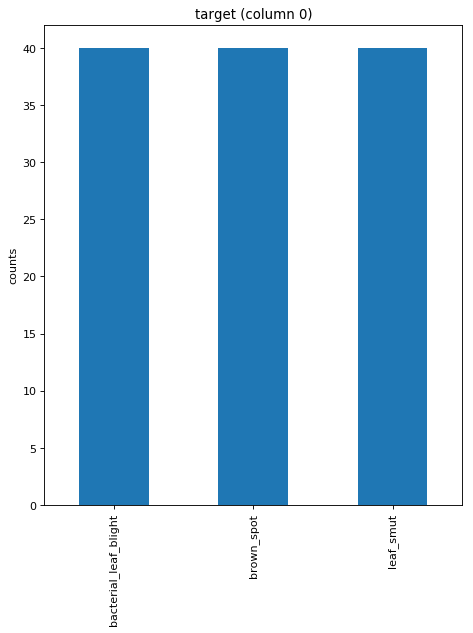

In [ ]:
plotPerColumnDistribution(df_data, 2, 1)

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
plotCorrelationMatrix(df_data, 12)

## Prepare the Data

### Create a dataframe containing all the images

In [ ]:
leaf_smut_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut')
brown_spot_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight')

print(len(leaf_smut_list))
print(len(brown_spot_list))
print(len(bacterial_leaf_blight_list))

40
40
40


In [ ]:
# Create the train and val sets

df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] = 'leaf_smut'

df_brown_spot = pd.DataFrame(brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'

df_bacterial_leaf_blight = pd.DataFrame(bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'


# Create a val set for each class

# Sample 5 validation images from each class
df_leaf_smut_val = df_leaf_smut.sample(n=5, random_state=101)
df_brown_spot_val = df_brown_spot.sample(n=5, random_state=101)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=5, random_state=101)


print(len(df_leaf_smut_val))
print(len(df_brown_spot_val))
print(len(df_bacterial_leaf_blight_val))

5
5
5


In [ ]:
# Create the train set for each class

# leaf_smut
# get a list of val images
val_list = list(df_leaf_smut_val['image'])
# filter out the val images
df_leaf_smut_train = df_leaf_smut[~df_leaf_smut['image'].isin(val_list)] # ~ means notin

# brown_spot
# get a list of val images
val_list = list(df_brown_spot_val['image'])
# filter out the val images
df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)] # ~ means notin

# bacterial_leaf_blight
# get a list of val images
val_list = list(df_bacterial_leaf_blight_val['image'])
# filter out the val images
df_bacterial_leaf_blight_train = \
df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)] # ~ means notin



print(len(df_leaf_smut_train))
print(len(df_brown_spot_train))
print(len(df_bacterial_leaf_blight_train))

35
35
35


In [ ]:
# Create df_data, df_train and df_val

df_data = pd.concat([df_leaf_smut, df_brown_spot, df_bacterial_leaf_blight], axis=0).reset_index(drop=True)

df_train = \
pd.concat([df_leaf_smut_train, df_brown_spot_train, df_bacterial_leaf_blight_train], axis=0).reset_index(drop=True)

df_val = \
pd.concat([df_leaf_smut_val, df_brown_spot_val, df_bacterial_leaf_blight_val], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print(df_data.shape)
print(df_train.shape)
print(df_val.shape)

(120, 2)
(105, 2)
(15, 2)


In [ ]:
df_data['target'].value_counts()

brown_spot               40
bacterial_leaf_blight    40
leaf_smut                40
Name: target, dtype: int64

In [ ]:
df_train['target'].value_counts()

brown_spot               35
bacterial_leaf_blight    35
leaf_smut                35
Name: target, dtype: int64

In [ ]:
df_val['target'].value_counts()

brown_spot               5
bacterial_leaf_blight    5
leaf_smut                5
Name: target, dtype: int64

### Transform the target 

Here we will one hot encode the target classes.

In [ ]:
# Create the target as index values

# combine val, train and test
val_len = len(df_val)
train_len = len(df_train)
df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

# create the dummy variables
df_combined = pd.get_dummies(df_combined, columns=['target'])

# separate the train and val sets
df_val = df_combined[:val_len]
df_train = df_combined[val_len:]


print(df_train.shape)
print(df_val.shape)

(105, 4)
(15, 4)


In [ ]:
df_combined.head()

image  target_bacterial_leaf_blight  target_brown_spot  \
0  DSC_0101.jpg                             0                  1   
1  DSC_0333.JPG                             0                  1   
2  DSC_0514.jpg                             0                  0   
3  DSC_0308.JPG                             0                  0   
4  DSC_0118.jpg                             0                  1   

   target_leaf_smut  
0                 0  
1                 0  
2                 1  
3                 1  
4                 0

In [ ]:
df_train.head()

image  target_bacterial_leaf_blight  target_brown_spot  \
15  DSC_0113.jpg                             0                  1   
16  DSC_0111.jpg                             0                  1   
17  DSC_0374.JPG                             1                  0   
18  DSC_0405.JPG                             1                  0   
19  DSC_0295.JPG                             0                  1   

    target_leaf_smut  
15                 0  
16                 0  
17                 0  
18                 0  
19                 0

In [ ]:
df_val.head()

image  target_bacterial_leaf_blight  target_brown_spot  \
0  DSC_0101.jpg                             0                  1   
1  DSC_0333.JPG                             0                  1   
2  DSC_0514.jpg                             0                  0   
3  DSC_0308.JPG                             0                  0   
4  DSC_0118.jpg                             0                  1   

   target_leaf_smut  
0                 0  
1                 0  
2                 1  
3                 1  
4                 0

## Save the dataframes as compressed csv files
These csv files will allow us to use Pandas chunking to feed images into the generators.

In [ ]:
df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)


In [ ]:
df_combined

image  target_bacterial_leaf_blight  target_brown_spot  \
0    DSC_0101.jpg                             0                  1   
1    DSC_0117.jpg                             0                  1   
2    DSC_0514.jpg                             0                  0   
3    DSC_0513.jpg                             0                  0   
4    DSC_0376.JPG                             1                  0   
..            ...                           ...                ...   
115  DSC_0319.jpg                             0                  0   
116  DSC_0391.jpg                             0                  1   
117  DSC_0405.JPG                             1                  0   
118  DSC_0338.JPG                             0                  0   
119  DSC_0386.JPG                             1                  0   

     target_leaf_smut  
0                   0  
1                   0  
2                   1  
3                   1  
4                   0  
..                ...  
115                 1  
116                 0  
117                 0  
118                 1  
119                 0  

[120 rows x 4 columns]

In [ ]:
!ls

__notebook_source__.ipynb  df_combined.csv.gz  df_train.csv.gz	df_val.csv.gz


### Move all images to the same folder

In [ ]:
# Create a new directory
image_dir = 'image_dir'
os.mkdir(image_dir)

!ls

__notebook_source__.ipynb  df_train.csv.gz  image_dir
df_combined.csv.gz	   df_val.csv.gz


In [ ]:
leaf_smut_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut')
brown_spot_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight')


# Transfer the leaf_smut images
for fname in leaf_smut_list:
    
    path = '../input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut/'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    
    
    
    
# Transfer the brown_spot images
for fname in brown_spot_list:
    
    path = '../input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    
    
    
    
# Transfer the bacterial_leaf_blight images
for fname in bacterial_leaf_blight_list:
    
    path = '../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
       

In [ ]:
# Check how many images are now in image_dir

len(os.listdir('image_dir'))

120

## Display  images by class and the detailed image processing 

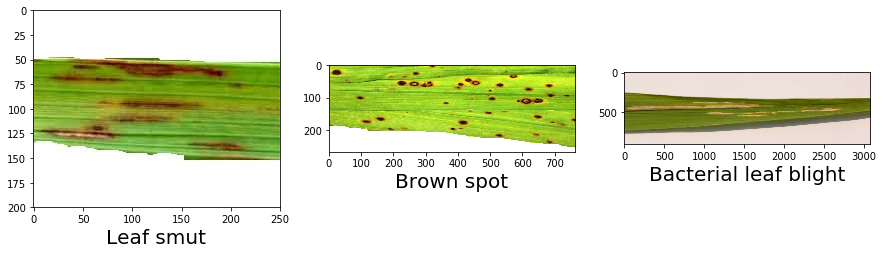

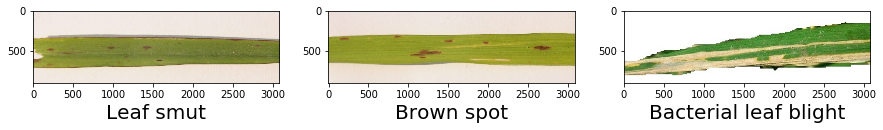

In [ ]:
# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0512.jpg'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0108.jpg'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 2
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0402.JPG'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)






# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0316.JPG'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0303.JPG'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 2
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0702.jpg'
path = '../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

plt.show()

In [ ]:
Blight


##Detailed report 

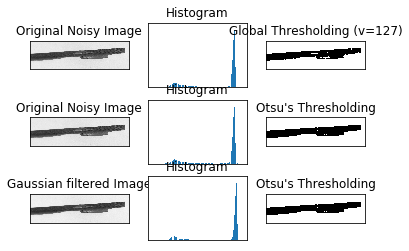

In [ ]:
#with histogram

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(r'../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG',0)

# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

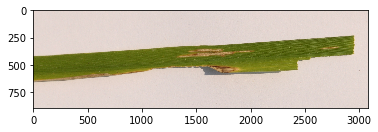

In [ ]:
img = cv2.imread(r'../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG')
b,g,r = cv2.split(img)           # get b, g, r
img_RGB2 = cv2.merge([r,g,b])     # switch it to r, g, b
plt.imshow(img_RGB2)

Histogram

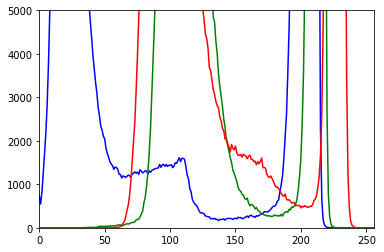

In [ ]:
color = ('b', 'g', 'r') 
for i, col in enumerate(color): 
    histr = cv2.calcHist([img], [i], None, [256], [0, 256]) 
    plt.plot(histr, color = col) 
    plt.xlim([0, 256])
    plt.ylim([0,5000])
plt.show() 

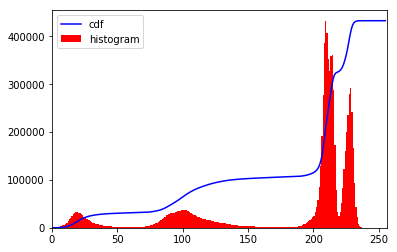

In [ ]:
img = cv2.imread(r'../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG')
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

Histogram equlaisation

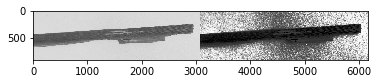

In [ ]:
img = cv2.imread(r'../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG',0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
plt.imshow(res,cmap='gray')

(0, 256)

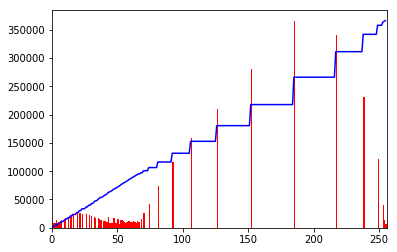

In [ ]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])


In [ ]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [ ]:
import cv2
img=cv2.imread(r'../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG',0)

erosian and dialation

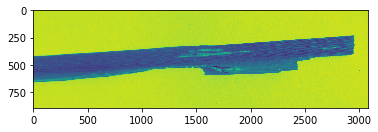

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Taking a matrix of size 5 as the kernel
kernel = np.ones((5,5), np.uint8)
  
# The first parameter is the original image,
# kernel is the matrix with which image is 
# convolved and third parameter is the number 
# of iterations, which will determine how much 
# you want to erode/dilate a given image. 
img_erosion = cv2.erode(img, kernel, iterations=10)
img_dilation = cv2.dilate(img, kernel, iterations=10)
  
plt.imshow( img)



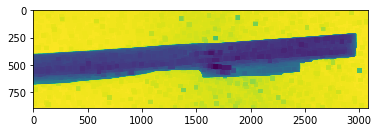

In [ ]:
plt.imshow( img_erosion)

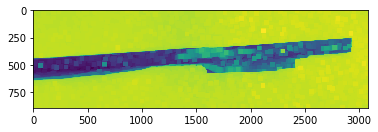

In [ ]:
plt.imshow( img_dilation)

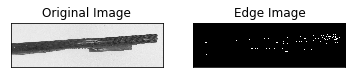

In [ ]:
#edge image
edges = cv2.Canny(img,50,250)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
#Iterate over each pixel and change pixel value to binary using np.binary_repr() and store it in a list.
lst = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
         lst.append(np.binary_repr(img[i][j] ,width=8)) # width = no. of bits

# We have a list of strings where each string represents binary pixel value. To extract bit planes we need to iterate over the strings and store the characters corresponding to bit planes into lists.
# Multiply with 2^(n-1) and reshape to reconstruct the bit image.
eight_bit_img = (np.array([int(i[0]) for i in lst],dtype = np.uint8) * 128).reshape(img.shape[0],img.shape[1])
seven_bit_img = (np.array([int(i[1]) for i in lst],dtype = np.uint8) * 64).reshape(img.shape[0],img.shape[1])
six_bit_img = (np.array([int(i[2]) for i in lst],dtype = np.uint8) * 32).reshape(img.shape[0],img.shape[1])
five_bit_img = (np.array([int(i[3]) for i in lst],dtype = np.uint8) * 16).reshape(img.shape[0],img.shape[1])
four_bit_img = (np.array([int(i[4]) for i in lst],dtype = np.uint8) * 8).reshape(img.shape[0],img.shape[1])
three_bit_img = (np.array([int(i[5]) for i in lst],dtype = np.uint8) * 4).reshape(img.shape[0],img.shape[1])
two_bit_img = (np.array([int(i[6]) for i in lst],dtype = np.uint8) * 2).reshape(img.shape[0],img.shape[1])
one_bit_img = (np.array([int(i[7]) for i in lst],dtype = np.uint8) * 1).reshape(img.shape[0],img.shape[1])


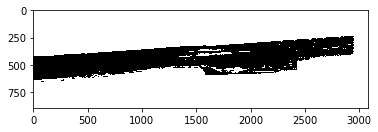

In [ ]:
# Display the images
plt.imshow(eight_bit_img,cmap='gray')


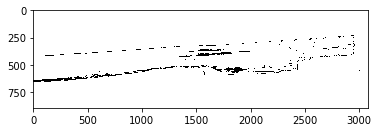

In [ ]:
plt.imshow(seven_bit_img,cmap='gray')

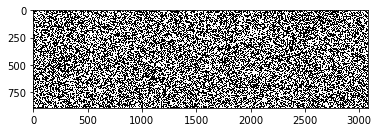

In [ ]:
# Display the images
plt.imshow(one_bit_img,cmap='gray')

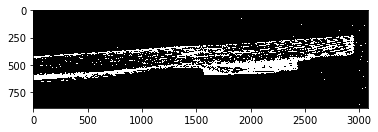

In [ ]:
plt.imshow(six_bit_img,cmap='gray')

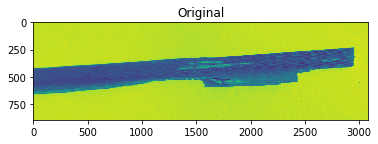

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:338: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


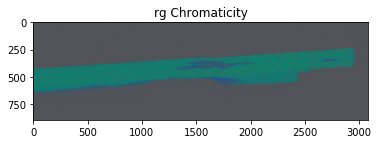

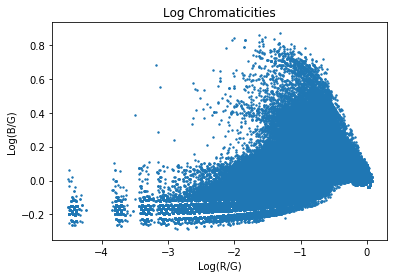

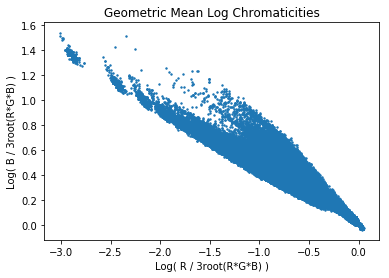

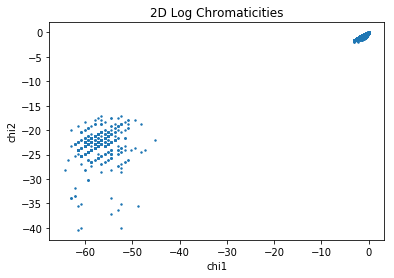

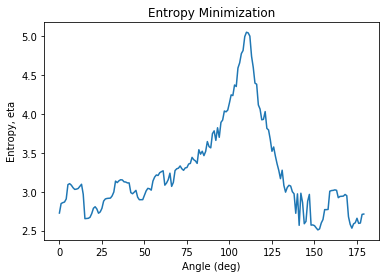

Min Angle:  152.0


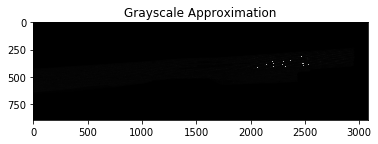

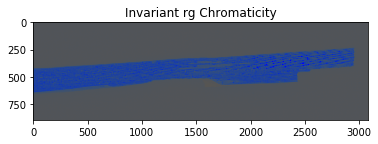

In [ ]:
import numpy as np
import cv2
import os
import sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import scipy
from scipy.optimize import leastsq
from scipy.stats.mstats import gmean
from scipy.signal import argrelextrema
from scipy.stats import entropy
from scipy.signal import savgol_filter

root = r'../input/rice-leaf-diseases/rice_leaf_diseases'
fl = r'../input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG'

#############
# PROGRAM
#############
if __name__ == '__main__':

    #-----------------------------------
    ## 1. Create Chromaticity Vectors ##
    #-----------------------------------

    # Get Image
    img = cv2.imread(fl,0)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    plt.imshow(img)
    plt.title('Original')
    plt.show()

    
    img = cv2.GaussianBlur(img, (5,5), 0)

    # Separate Channels
    img=img = cv2.imread(fl)
    r, g, b = cv2.split(img) 

    im_sum = np.sum(img, axis=2)
    im_mean = gmean(img, axis=2)

    # Create "normalized", mean, and rg chromaticity vectors
    #  We use mean (works better than norm). rg Chromaticity is
    #  for visualization
    n_r = np.ma.divide( 1.*r, g )
    n_b = np.ma.divide( 1.*b, g )

    mean_r = np.ma.divide(1.*r, im_mean)
    mean_g = np.ma.divide(1.*g, im_mean)
    mean_b = np.ma.divide(1.*b, im_mean)

    rg_chrom_r = np.ma.divide(1.*r, im_sum)
    rg_chrom_g = np.ma.divide(1.*g, im_sum)
    rg_chrom_b = np.ma.divide(1.*b, im_sum)

    # Visualize rg Chromaticity --> DEBUGGING
    rg_chrom = np.zeros_like(img)

    rg_chrom[:,:,0] = np.clip(np.uint8(rg_chrom_r*255), 0, 255)
    rg_chrom[:,:,1] = np.clip(np.uint8(rg_chrom_g*255), 0, 255)
    rg_chrom[:,:,2] = np.clip(np.uint8(rg_chrom_b*255), 0, 255)

    plt.imshow(rg_chrom)
    plt.title('rg Chromaticity')
    plt.show()

    #-----------------------
    ## 2. Take Logarithms ##
    #-----------------------

    l_rg = np.ma.log(n_r)
    l_bg = np.ma.log(n_b)

    log_r = np.ma.log(mean_r)
    log_g = np.ma.log(mean_g)
    log_b = np.ma.log(mean_b)

    ##  rho = np.zeros_like(img, dtype=np.float64)
    ##
    ##  rho[:,:,0] = log_r
    ##  rho[:,:,1] = log_g
    ##  rho[:,:,2] = log_b

    rho = cv2.merge((log_r, log_g, log_b))

    # Visualize Logarithms --> DEBUGGING
    plt.scatter(l_rg, l_bg, s = 2)
    plt.xlabel('Log(R/G)')
    plt.ylabel('Log(B/G)')
    plt.title('Log Chromaticities')
    plt.show()

    plt.scatter(log_r, log_b, s = 2)
    plt.xlabel('Log( R / 3root(R*G*B) )')
    plt.ylabel('Log( B / 3root(R*G*B) )')
    plt.title('Geometric Mean Log Chromaticities')
    plt.show()

    #----------------------------
    ## 3. Rotate through Theta ##
    #----------------------------
    u = 1./np.sqrt(3)*np.array([[1,1,1]]).T
    I = np.eye(3)

    tol = 1e-15

    P_u_norm = I - u.dot(u.T)
    U_, s, V_ = np.linalg.svd(P_u_norm, full_matrices = False)

    s[ np.where( s <= tol ) ] = 0.

    U = np.dot(np.eye(3)*np.sqrt(s), V_)
    U = U[ ~np.all( U == 0, axis = 1) ].T

    # Columns are upside down and column 2 is negated...?
    U = U[::-1,:]
    U[:,1] *= -1.

    ##  TRUE ARRAY:
    ##
    ##  U = np.array([[ 0.70710678,  0.40824829],
    ##                [-0.70710678,  0.40824829],
    ##                [ 0.        , -0.81649658]])

    chi = rho.dot(U) 

    # Visualize chi --> DEBUGGING
    plt.scatter(chi[:,:,0], chi[:,:,1], s = 2)
    plt.xlabel('chi1')
    plt.ylabel('chi2')
    plt.title('2D Log Chromaticities')
    plt.show()

    e = np.array([[np.cos(np.radians(np.linspace(1, 180, 180))), \
                   np.sin(np.radians(np.linspace(1, 180, 180)))]])

    gs = chi.dot(e)

    prob = np.array([np.histogram(gs[...,i], bins='scott', density=True)[0] 
                      for i in range(np.size(gs, axis=3))])

    eta = np.array([entropy(p, base=2) for p in prob])

    plt.plot(eta)
    plt.xlabel('Angle (deg)')
    plt.ylabel('Entropy, eta')
    plt.title('Entropy Minimization')
    plt.show()

    theta_min = np.radians(np.argmin(eta))

    print('Min Angle: ', np.degrees(theta_min))

    e = np.array([[-1.*np.sin(theta_min)],
                  [np.cos(theta_min)]])

    gs_approx = chi.dot(e)

    # Visualize Grayscale Approximation --> DEBUGGING
    plt.imshow(gs_approx.squeeze(), cmap='gray')
    plt.title('Grayscale Approximation')
    plt.show()

    P_theta = np.ma.divide( np.dot(e, e.T), np.linalg.norm(e) )

    chi_theta = chi.dot(P_theta)
    rho_estim = chi_theta.dot(U.T)
    mean_estim = np.ma.exp(rho_estim)

    estim = np.zeros_like(mean_estim, dtype=np.float64)

    estim[:,:,0] = np.divide(mean_estim[:,:,0], np.sum(mean_estim, axis=2))
    estim[:,:,1] = np.divide(mean_estim[:,:,1], np.sum(mean_estim, axis=2))
    estim[:,:,2] = np.divide(mean_estim[:,:,2], np.sum(mean_estim, axis=2))

    plt.imshow(estim)
    plt.title('Invariant rg Chromaticity')
    plt.show()

In [ ]:
def point_operation(img, K, L):
    """ Applies point operation to given grayscale image """ 
    img = np.asarray(img, dtype=np.float) 
    img = img*K + L 
    # clip pixel values 
    img[img > 255] = 255 
    img[img < 0] = 0 
    return np.asarray(img, dtype = np.int)

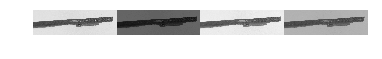

In [ ]:
# k = 0.5, l = 0 
out1 = point_operation(img, 0.5, 0) 
# k = 1., l = 10 
out2 = point_operation(img, 1., 10) 
# k = 0.8, l = 15 
out3 = point_operation(img, 0.7, 25) 
res = np.hstack([img,out1, out2, out3])
plt.imshow(res, cmap='gray') 
plt.axis('off')
plt.show()

## Set up and test the Augmentations

In [ ]:


import albumentations as albu


def augment_image(augmentation, image):
    
    """
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    
    return image_matrix



In [ ]:
# Define the transforms


aug_types = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])



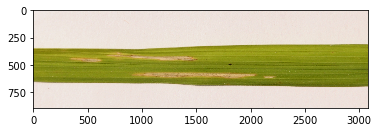

In [ ]:
# Get an image to test transformations

# get a list of train png images
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

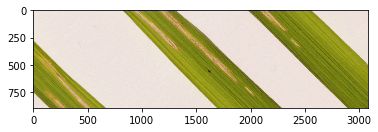

In [ ]:
# Test the transformation setup.
# The image will be different each time this cell is run.

aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

## Build the Data Generators

### [ 1 ] Train Generator

In [ ]:
df_train.head()

image  target_bacterial_leaf_blight  target_brown_spot  \
15  DSC_0383.JPG                             1                  0   
16  DSC_0112.jpg                             0                  1   
17  DSC_0406.JPG                             1                  0   
18  DSC_0330.jpg                             0                  0   
19  DSC_0378.JPG                             1                  0   

    target_leaf_smut  
15                 0  
16                 0  
17                 0  
18                 1  
19                 0

In [ ]:
def train_generator(batch_size=8):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create y_train
            # ===============
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train) 

                # change the shape to (batch_size, 1)
                #y_train = y_train.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size
       
              
            # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                          
                
            # Normalize the images
            X_train = X_train/255

            yield X_train, y_train

In [ ]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)


In [ ]:
y_train

array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

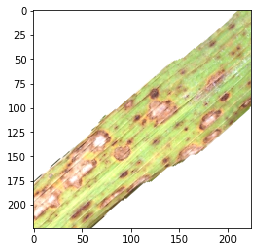

In [ ]:
# Print the first image in X_train
# Remember that train images have been augmented.

image = X_train[0,:,:,:]
plt.imshow(image)

### [ 2 ] Val Generator

In [ ]:
def val_generator(batch_size=5):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_val
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_val[i] = image
                
                
            
            
            # Create y_val
            # ===============

                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_val = df[cols]
                y_val = np.asarray(y_val) 

                # change the shape to (batch_size, 1)
                #y_val = y_val.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size
       
            
                
                          
                
            # Normalize the images
            X_val = X_val/255

            yield X_val, y_val

In [ ]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=5)

# run the generator
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 3)


In [ ]:
y_val

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]])

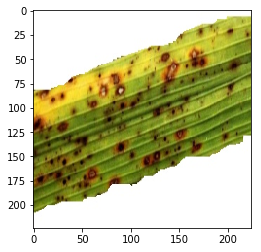

In [ ]:
# print the image from X_val
image = X_val[0,:,:,:]
plt.imshow(image)

### [ 3 ] Test Generator

In [ ]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_test
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_test[i] = image
                
                 
                
            # Normalize the images
            X_test = X_test/255

            yield X_test

In [ ]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=1)

# run the generator
X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


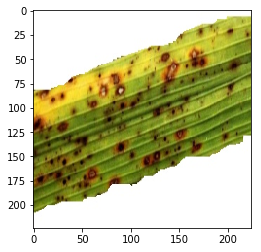

In [ ]:
# print the image from X_test

image = X_test[0,:,:,:]
plt.imshow(image)

## Model Architecture

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50


In [ ]:
model = ResNet50( weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

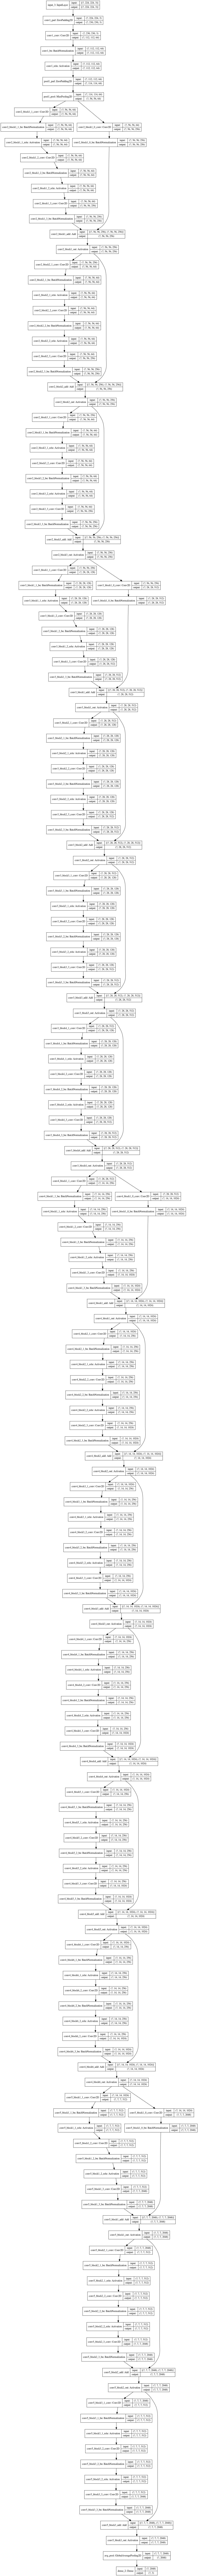

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, to_file='model.png')

In [ ]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   #verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

Train for 14.0 steps, validate for 3.0 steps
Epoch 1/20
13/14 [==========================>...] - ETA: 3s - loss: 0.9264 - accuracy: 0.5673
Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to model.h5
14/14 [==============================] - 46s 3s/step - loss: 0.9295 - accuracy: 0.5714 - val_loss: 1.4768 - val_accuracy: 0.3333
Epoch 2/20
13/14 [==========================>...] - ETA: 2s - loss: 0.3188 - accuracy: 0.8558
Epoch 00002: val_accuracy did not improve from 0.33333
14/14 [==============================] - 37s 3s/step - loss: 0.3216 - accuracy: 0.8571 - val_loss: 1.1232 - val_accuracy: 0.3333
Epoch 3/20
13/14 [==========================>...] - ETA: 2s - loss: 0.1809 - accuracy: 0.9327
Epoch 00003: val_accuracy did not improve from 0.33333
14/14 [==============================] - 37s 3s/step - loss: 0.1701 - accuracy: 0.9333 - val_loss: 1.1198 - val_accuracy: 0.3333
Epoch 4/20
13/14 [==========================>...] - ETA: 2s - loss: 0.1093 - accuracy: 0.9615


In [ ]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   #verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

Train for 14.0 steps, validate for 3.0 steps
Epoch 1/20
13/14 [==========================>...] - ETA: 0s - loss: 0.8179 - accuracy: 0.6538
Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to model.h5
14/14 [==============================] - 16s 1s/step - loss: 0.8421 - accuracy: 0.6476 - val_loss: 1.2461 - val_accuracy: 0.3333
Epoch 2/20
13/14 [==========================>...] - ETA: 0s - loss: 0.3748 - accuracy: 0.8750
Epoch 00002: val_accuracy did not improve from 0.33333
14/14 [==============================] - 4s 289ms/step - loss: 0.3996 - accuracy: 0.8762 - val_loss: 3.0904 - val_accuracy: 0.3333
Epoch 3/20
13/14 [==========================>...] - ETA: 0s - loss: 0.2383 - accuracy: 0.9038
Epoch 00003: val_accuracy did not improve from 0.33333
14/14 [==============================] - 4s 302ms/step - loss: 0.2587 - accuracy: 0.9048 - val_loss: 2.0239 - val_accuracy: 0.3333
Epoch 4/20
13/14 [==========================>...] - ETA: 0s - loss: 0.1399 - accuracy: 0.9

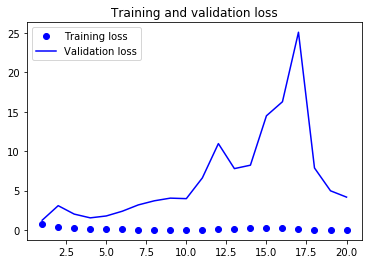

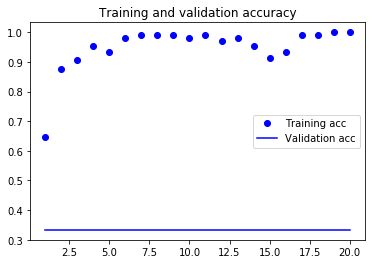

<Figure size 432x288 with 0 Axes>

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

In [ ]:
# Display the training log

train_log = pd.read_csv('training_log.csv')

train_log.head(20)

epoch  accuracy      loss  val_accuracy   val_loss
0       0  0.647619  0.821327      0.333333   1.246065
1       1  0.876191  0.378346      0.333333   3.090406
2       2  0.904762  0.241185      0.333333   2.023871
3       3  0.952381  0.140889      0.333333   1.547096
4       4  0.933333  0.138778      0.333333   1.786443
5       5  0.980952  0.091244      0.333333   2.387250
6       6  0.990476  0.068718      0.333333   3.187201
7       7  0.990476  0.034036      0.333333   3.708654
8       8  0.990476  0.028871      0.333333   4.046752
9       9  0.980952  0.058087      0.333333   3.982987
10     10  0.990476  0.029612      0.333333   6.611713
11     11  0.971429  0.081569      0.333333  10.958973
12     12  0.980952  0.078868      0.333333   7.789813
13     13  0.952381  0.212710      0.333333   8.223049
14     14  0.914286  0.283903      0.333333  14.483142
15     15  0.933333  0.207816      0.333333  16.264563
16     16  0.990476  0.117081      0.333333  25.074504
17     17  0.990476  0.056689      0.333333   7.870206
18     18  1.000000  0.025960      0.333333   4.976695
19     19  1.000000  0.018495      0.333333   4.175629

In [ ]:
test_gen = test_generator(batch_size=1)

preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
# get y_pred as index values

y_pred = np.argmax(preds, axis=1)

print(y_pred)
# get y_true as index values

cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true) 

y_true = np.argmax(y_true, axis=1)

print(y_true)




15/15 [==============================] - 1s 81ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 2 2 0 0 0 1 0 2 2 0 1 2 1]


In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

                       precision    recall  f1-score   support

bacterial_leaf_blight       0.33      1.00      0.50         5
           brown_spot       0.00      0.00      0.00         5
            leaf_smut       0.00      0.00      0.00         5

             accuracy                           0.33        15
            macro avg       0.11      0.33      0.17        15
         weighted avg       0.11      0.33      0.17        15



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# create the base pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
model =InceptionV3(weights='imagenet')
# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, to_file='model.png')
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   #verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
____________________________________________________________

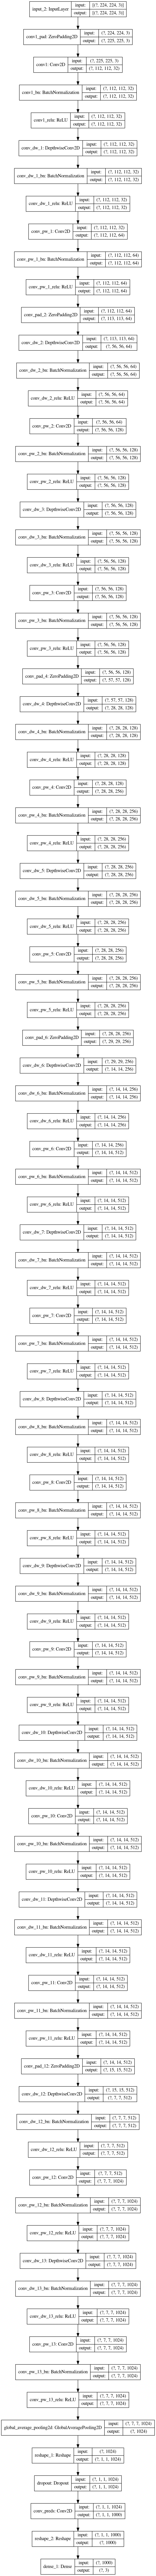

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, to_file='model.png')

## Train the Model

In [ ]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   #verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=100, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

Train for 14.0 steps, validate for 3.0 steps
Epoch 1/100
13/14 [==========================>...] - ETA: 1s - loss: 1.8771 - accuracy: 0.5385
Epoch 00001: val_accuracy improved from -inf to 0.66667, saving model to model.h5
14/14 [==============================] - 16s 1s/step - loss: 1.7697 - accuracy: 0.5429 - val_loss: 2.0914 - val_accuracy: 0.6667
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 0.8468 - accuracy: 0.7692
Epoch 00002: val_accuracy improved from 0.66667 to 0.73333, saving model to model.h5
14/14 [==============================] - 13s 902ms/step - loss: 0.8388 - accuracy: 0.7714 - val_loss: 1.3668 - val_accuracy: 0.7333
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 0.5099 - accuracy: 0.8462
Epoch 00003: val_accuracy did not improve from 0.73333
14/14 [==============================] - 12s 888ms/step - loss: 0.4768 - accuracy: 0.8476 - val_loss: 1.2215 - val_accuracy: 0.7333
Epoch 4/100
13/14 [==========================>...] - ET

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
# Display the training log

train_log = pd.read_csv('training_log.csv')

train_log.head()

epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.542857  1.861931      0.666667  2.091432
1      1  0.771429  0.845633      0.733333  1.366760
2      2  0.847619  0.505214      0.733333  1.221510
3      3  0.857143  0.471547      0.733333  1.054260
4      4  0.885714  0.340497      0.666667  0.966956

## Evaluate the model on the val set

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [ ]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=1)

val_loss, val_acc = \
model.evaluate_generator(val_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.03532594116709286
val_acc: 1.0


## Plot the training curves

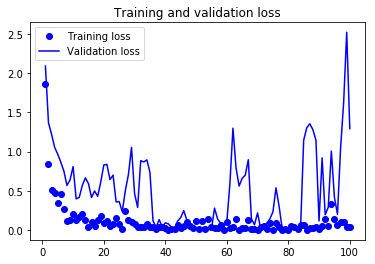

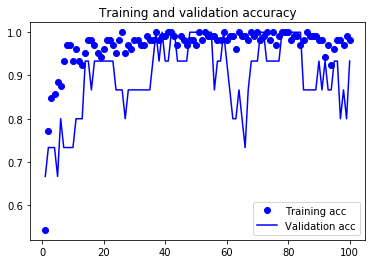

<Figure size 432x288 with 0 Axes>

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

## Make a prediction on the val set

In [ ]:
test_gen = test_generator(batch_size=1)

preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


15/15 [==============================] - 1s 67ms/step


In [ ]:
# get y_pred as index values

y_pred = np.argmax(preds, axis=1)

y_pred

array([1, 1, 2, 2, 1, 0, 0, 0, 2, 2, 1, 2, 1, 0, 0])

In [ ]:
# get y_true as index values

cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true) 

y_true = np.argmax(y_true, axis=1)

y_true

array([1, 1, 2, 2, 1, 0, 0, 0, 2, 2, 1, 2, 1, 0, 0])

In [ ]:
# Compare y_true and y_pred

print(y_pred)
print(y_true)

[1 1 2 2 1 0 0 0 2 2 1 2 1 0 0]
[1 1 2 2 1 0 0 0 2 2 1 2 1 0 0]


In [ ]:
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)

In [ ]:
# bacterial_leaf_blight = 0
# brown_spot = 1
# leaf_smut = 2

cm_plot_labels = ['leaf_blight', 'brown_spot', 'leaf_smut']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00         5
           brown_spot       1.00      1.00      1.00         5
            leaf_smut       1.00      1.00      1.00         5

             accuracy                           1.00        15
            macro avg       1.00      1.00      1.00        15
         weighted avg       1.00      1.00      1.00        15



**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

## Convert the Model to Tensorflow.js

In [ ]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

     |████████████████████████████████| 63 kB 1.0 MB/s eta 0:00:011
     |████████████████████████████████| 2.9 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 27.8 MB/s eta 0:00:01
     |████████████████████████████████| 394.3 MB 21 kB/s s eta 0:00:01��█████████████▏              | 211.9 MB 63.6 MB/s eta 0:00:03     |██████████████████▉             | 231.6 MB 52.2 MB/s eta 0:00:04     |███████████████████             | 235.2 MB 52.2 MB/s eta 0:00:04     |███████████████████▎            | 237.0 MB 52.2 MB/s eta 0:00:04███████████████████▍            | 239.0 MB 52.2 MB/s eta 0:00:03     |███████████████████████         | 284.0 MB 64.3 MB/s eta 0:00:02     |████████████████████████▎       | 299.8 MB 64.3 MB/s eta 0:00:02     |█████████████████████████▋      | 315.6 MB 57.7 MB/s eta 0:00:02     |█████████████████████████▉      | 318.6 MB 57.7 MB/s eta 0:00:02     |██████████████████████████      | 320.3 MB 57.7 MB/s eta 0:00:02
     |████████████████████████████████

In [ ]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs/model/''

In [ ]:
# check that the folder containing the tfjs model files has been created
!ls

__notebook_source__.ipynb  df_train.csv.gz  image_dir  training_log.csv
df_combined.csv.gz	   df_val.csv.gz    model.h5
